In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_cost` function below:

In [4]:
### SOLUTION
def calculate_mse(e):
    """Calculate the mse for vector e."""
    return 1 / 2 * np.mean(e**2)


def calculate_mae(e):
    """Calculate the mae for vector e."""
    return np.mean(np.abs(e))


### TEMPLATE
### END SOLUTION


def compute_loss(y, tx, w):

    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    ### SOLUTION
    e = y - tx.dot(w)
    return calculate_mse(e)
    ### TEMPLATE
    # # ***************************************************
    # # INSERT YOUR CODE HERE
    # # TODO: compute loss by MSE
    # # ***************************************************
    # raise NotImplementedError
    ### END SOLUTION

# 2. Grid Search

Fill in the function `grid_search()` below:

In [5]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    ### SOLUTION
    # compute loss for each combinationof w0 and w1.
    for ind_row, row in enumerate(grid_w0):
        for ind_col, col in enumerate(grid_w1):
            w = np.array([row, col])
            losses[ind_row, ind_col] = compute_loss(y, tx, w)
    ### TEMPLATE
    # # ***************************************************
    # # INSERT YOUR CODE HERE
    # # TODO: compute loss for each combination of w0 and w1.
    # # ***************************************************
    # raise NotImplementedError
    ### END SOLUTION
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=42.42448314678248, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.007 seconds


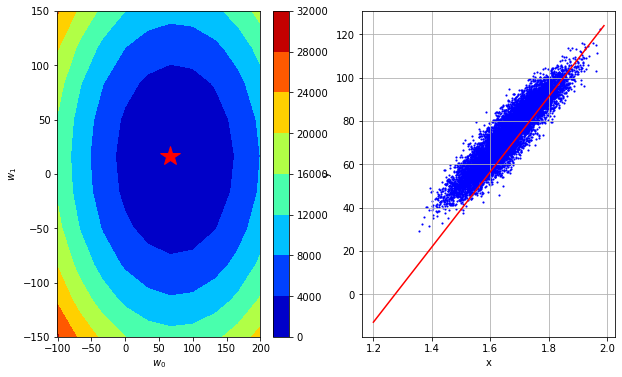

In [6]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [7]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    ### SOLUTION
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

    ### TEMPLATE
    # # ***************************************************
    # # INSERT YOUR CODE HERE
    # # TODO: compute gradient vector
    # # ***************************************************
    # raise NotImplementedError
    ### END SOLUTION

Please fill in the functions `gradient_descent` below:

In [8]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        ### SOLUTION
        # compute loss, gradient
        grad, err = compute_gradient(y, tx, w)
        loss = calculate_mse(err)
        # update w by gradient descent
        w = w - gamma * grad

        ### TEMPLATE
        # # ***************************************************
        # # INSERT YOUR CODE HERE
        # # TODO: compute gradient and loss
        # # ***************************************************
        # raise NotImplementedError
        # # ***************************************************
        # # INSERT YOUR CODE HERE
        # # TODO: update w by gradient
        # # ***************************************************
        # raise NotImplementedError
        ### END SOLUTION

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [9]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.2367127591674, w0=51.305745401473644, w1=9.435798704492269
GD iter. 1/49: loss=265.3024621089598, w0=66.69746902191571, w1=12.266538315840005
GD iter. 2/49: loss=37.87837955044126, w0=71.31498610804834, w1=13.115760199244333
GD iter. 3/49: loss=17.410212120174467, w0=72.70024123388814, w1=13.370526764265632
GD iter. 4/49: loss=15.568077051450455, w0=73.11581777164007, w1=13.446956733772023
GD iter. 5/49: loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=15.38736360120863, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/49: loss=15.38602068474353, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=15.385888944638305, w0=73.29348920882515, w1=13.47963283863509
GD iter. 10/49: loss=15.3858879656522, w0=73.29379216412117, w1=13.479688556082861
GD iter. 11/49: loss=15.385887877543452, w0=73.29388305070998, w1=13.47970527131719

In [10]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [11]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    ### SOLUTION
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

    ### TEMPLATE
    # # ***************************************************
    # # INSERT YOUR CODE HERE
    # # TODO: implement stochastic gradient computation. It's the same as the usual gradient.
    # # ***************************************************
    # raise NotImplementedError
    ### END SOLUTION


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        ### SOLUTION
        for y_batch, tx_batch in batch_iter(
            y, tx, batch_size=batch_size, num_batches=1
        ):
            # compute a stochastic gradient and loss
            grad, _ = compute_stoch_gradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # calculate loss
            loss = compute_loss(y, tx, w)
            # store w and loss
            ws.append(w)
            losses.append(loss)

        ### TEMPLATE
        # # ***************************************************
        # # INSERT YOUR CODE HERE
        # # TODO: implement stochastic gradient descent.
        # # ***************************************************
        # raise NotImplementedError
        ### END SOLUTION

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [12]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2127.7602707005312, w0=8.612715904649866, w1=7.069537441908745
SGD iter. 1/49: loss=1671.1560635302933, w0=15.876288608742268, w1=9.638394063869118
SGD iter. 2/49: loss=1314.8277057136315, w0=22.558963958548667, w1=18.46445595980181
SGD iter. 3/49: loss=1043.0372198998787, w0=28.056011911123676, w1=10.507481847976702
SGD iter. 4/49: loss=835.958407052763, w0=32.819347644527426, w1=15.198394761882463
SGD iter. 5/49: loss=679.6596301110673, w0=36.84473239094948, w1=13.543439779940586
SGD iter. 6/49: loss=561.9358158090853, w0=40.42174853015157, w1=17.018083120813255
SGD iter. 7/49: loss=458.5407699128821, w0=43.74221447735405, w1=17.08614369867228
SGD iter. 8/49: loss=349.70419865198454, w0=47.600765956295454, w1=10.564518792710516
SGD iter. 9/49: loss=310.55712462516436, w0=49.4250911560246, w1=8.938634638489429
SGD iter. 10/49: loss=239.20226714326995, w0=52.25042589792863, w1=11.287902620614837
SGD iter. 11/49: loss=193.41687482039038, w0=54.42541110981511, w1=13.

In [13]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [14]:
import datetime
from helpers import *

### SOLUTION
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
### TEMPLATE
## ***************************************************
## INSERT YOUR CODE HERE
## TODO: reload the data by subsampling first, then by subsampling and adding outliers
## ***************************************************
# raise NotImplementedError
### END SOLUTION

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [15]:
y.shape, tx.shape

((202,), (202, 2))

In [16]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

### SOLUTION
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
### TEMPLATE
# # ***************************************************
# # INSERT YOUR CODE HERE
# # TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
# #       and the model fit
# # ***************************************************
# raise NotImplementedError
### END SOLUTION


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358524, w0=51.84746409844842, w1=7.7244264061924195
GD iter. 1/49: loss=318.2821247015965, w0=67.40170332798297, w1=10.041754328050114
GD iter. 2/49: loss=88.6423556165128, w0=72.06797509684336, w1=10.736952704607411
GD iter. 3/49: loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574597
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631798
GD iter. 6/49: loss=65.93222021235334, w0=74.0516072257859, w1=11.032481534481914
GD iter. 7/49: loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536945
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038408
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003895
GD iter. 11/49: loss=65.93073011140233, w0=74.06776649225755, w1=11.034889001593541
GD it

In [17]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [18]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    ### SOLUTION
    err = y - tx.dot(w)
    grad = -np.dot(tx.T, np.sign(err)) / len(err)
    return grad, err
    ### TEMPLATE
    # # ***************************************************
    # # INSERT YOUR CODE HERE
    # # TODO: compute subgradient gradient vector for MAE
    # # ***************************************************
    # raise NotImplementedError
    ### END SOLUTION

In [19]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        ### SOLUTION
        # compute loss, gradient
        grad, err = compute_subgradient_mae(y, tx, w)
        loss = calculate_mae(err)
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss

        ### TEMPLATE
        # # ***************************************************
        # # INSERT YOUR CODE HERE
        # # TODO: compute subgradient and loss
        # # ***************************************************
        # raise NotImplementedError
        # # ***************************************************
        # # INSERT YOUR CODE HERE
        # # TODO: update w by subgradient
        # # ***************************************************
        # raise NotImplementedError
        ### END SOLUTION

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [20]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=74.06780585492638, w0=0.7, w1=6.109524327590712e-16
SubGD iter. 1/499: loss=73.36780585492637, w0=1.4, w1=1.2219048655181425e-15
SubGD iter. 2/499: loss=72.66780585492637, w0=2.0999999999999996, w1=1.832857298277214e-15
SubGD iter. 3/499: loss=71.96780585492638, w0=2.8, w1=2.443809731036285e-15
SubGD iter. 4/499: loss=71.26780585492638, w0=3.5, w1=3.054762163795356e-15
SubGD iter. 5/499: loss=70.56780585492638, w0=4.2, w1=3.665714596554428e-15
SubGD iter. 6/499: loss=69.86780585492637, w0=4.9, w1=4.276667029313499e-15
SubGD iter. 7/499: loss=69.16780585492639, w0=5.6000000000000005, w1=4.887619462072571e-15
SubGD iter. 8/499: loss=68.46780585492637, w0=6.300000000000001, w1=5.498571894831642e-15
SubGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000001, w1=6.109524327590714e-15
SubGD iter. 10/499: loss=67.06780585492638, w0=7.700000000000001, w1=6.720476760349785e-15
SubGD iter. 11/499: loss=66.36780585492637, w0=8.4, w1=7.331429193108857e-15
SubGD iter. 1

In [21]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [22]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):

        ### SOLUTION
        for y_batch, tx_batch in batch_iter(
            y, tx, batch_size=batch_size, num_batches=1
        ):
            # compute a stochastic subgradient and loss
            grad, err = compute_subgradient_mae(y_batch, tx_batch, w)
            # update w through the stochastic subgradient update
            w = w - gamma * grad
            # calculate loss
            loss = calculate_mae(err)
            # store w and loss
            ws.append(w)
            losses.append(loss)

        ### TEMPLATE
        # # ***************************************************
        # # INSERT YOUR CODE HERE
        # # TODO: implement stochastic subgradient descent.
        # # ***************************************************
        # raise NotImplementedError
        ### END SOLUTION

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [23]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=65.54668940257886, w0=0.7, w1=-0.3755858382865697
SubSGD iter. 1/499: loss=61.164956325951806, w0=1.4, w1=-0.8065965230351835
SubSGD iter. 2/499: loss=94.48253686328121, w0=2.0999999999999996, w1=-0.14345220599213582
SubSGD iter. 3/499: loss=75.39413419310632, w0=2.8, w1=0.02235405357536127
SubSGD iter. 4/499: loss=87.24017878568914, w0=3.5, w1=0.9020841834078396
SubSGD iter. 5/499: loss=58.11081725494887, w0=4.2, w1=0.22373718743329662
SubSGD iter. 6/499: loss=50.86968622452161, w0=4.9, w1=-0.3343865163157427
SubSGD iter. 7/499: loss=76.2587196339863, w0=5.6000000000000005, w1=-0.13786643353723996
SubSGD iter. 8/499: loss=50.16884214971571, w0=6.300000000000001, w1=-0.6733861163634454
SubSGD iter. 9/499: loss=51.46904134396671, w0=7.000000000000001, w1=-1.2003431521322931
SubSGD iter. 10/499: loss=104.46339382150933, w0=7.700000000000001, w1=0.3397191862548927
SubSGD iter. 11/499: loss=51.093336919155774, w0=8.4, w1=0.05979019381842954
SubSGD iter. 12/499: los

In [24]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>